# Make all the plots in the paper but better (for thesis)

Use all the data, sort out the formatting.

---

In [1]:
import os
from pathlib import Path

import alphashape as ap
import descartes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import shapely
from alphashape.optimizealpha import _testalpha
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

plt.style.use("seaborn-colorblind")
%matplotlib inline

In [2]:
IMGS = Path("../img/")
DATA = Path("../new_data/")

epochs = range(0, 101, 10)
edgecolors = {0: "lightgray", 1: "k", 2: "gray"}

## Fitness functions

In [3]:
def _scale_dataframe(dataframe):

    return MinMaxScaler().fit_transform(dataframe)

In [4]:
def inertia(dataframe, n_clusters=3, n_seeds=5):
    """ Cluster the data into `n_clusters` parts across `n_seeds` runs and
    return the minimum inertia. Record labelling (for post-run analysis.) """

    data = _scale_dataframe(dataframe)
    inertias, labels, centres = [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(data)
        inertias.append(km.inertia_)
        labels.append(km.labels_)
        centres.append(km.cluster_centers_)

    best = min(inertias)
    idx = inertias.index(best)
    return best, labels[idx], centres[idx]

In [5]:
def silhouette(dataframe, n_clusters=3, n_seeds=5):
    """ Cluster the data into `n_clusters` parts across `n_seeds` runs and
    return the minimum inertia. Record labelling (for post-run analysis.) """

    data = _scale_dataframe(dataframe)
    silhouettes, inertias, labels, centres = [], [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(data)
        silhouettes.append(silhouette_score(dataframe, km.labels_))
        inertias.append(km.inertia_)
        labels.append(km.labels_)
        centres.append(km.cluster_centers_)

    best = max(silhouettes)
    idx = silhouettes.index(best)
    return best, inertias[idx], labels[idx], centres[idx]

## Plot functions

### Progressions

In [6]:
def progression_boxplot(
    summary, column, ylabel, epochs=None, ylims=None, filename=None
):
    """ Create boxplots for the progression of an attribute in an experiment summary. """

    _, ax = plt.subplots(dpi=300)

    if epochs:
        summary = summary[summary["generation"].isin(epochs)]

    data = summary.groupby("generation")[column]

    flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

    xticklabels = []
    for pos, (epoch, subdata) in enumerate(data):
        ax.boxplot(subdata, positions=[pos], widths=0.5, flierprops=flierprops)
        xticklabels.append(epoch)

    ax.set(
        xticklabels=xticklabels,
        xlabel="Generation",
        ylabel=ylabel,
        ylim=ylims,
    )

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

### Scattering individuals in k-means experiments

In [7]:
def kmeans_individuals_scatterplot(out, fitness, fitness_labels, filename=None):
    """ Plot side-by-side scatters for the representative individuals in a k-means experiment. """

    _, axes = plt.subplots(ncols=3, figsize=(12, 4), dpi=300)
    
    for quantile, ax in zip(("0", "0.5", "1"), axes):

        dataframe = pd.read_csv(out / quantile / "main.csv")
        sc = MinMaxScaler().fit(dataframe)
        data = sc.transform(dataframe)
        *fits, labels, centres = fitness(dataframe)

        ax.scatter(data[:, 0], data[:, 1], s=100, c=labels, lw=1, ec=[edgecolors[l] for l in labels])
        ax.scatter(
            centres[:, 0],
            centres[:, 1],
            marker="X",
            s=200,
            c=[0, 1, 2],
            ec=["lightgray", "k", "gray"],
            lw=1,
        )

        title_parts = [f"Quantile {float(quantile):.1f}"]
        for label, fit in zip(fitness_labels, fits):
            title_parts.append(f"{label.title()} {fit:.2f}")
        
        ax.set(
            xlim=(-0.1, 1.1),
            ylim=(-0.1, 1.1),
            aspect="equal",
            title="\n".join(title_parts),
        )

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

### Scattering individuals with hulls

In [8]:
def get_labels_and_score(data, method):
    """ Get the clustering method object and the silhouette score of the dataset. """

    if method == "kmeans":
        score, _, labels, _ = silhouette(data)
        score = round(score, 2)
    if method == "dbscan":
        db = DBSCAN(eps=0.14, min_samples=5).fit(data)
        outlier_mask = db.labels_ == -1
        labels = db.labels_
        inlabels = labels[~outlier_mask]
        inliers = data[~outlier_mask, :]

        try:
            score = silhouette_score(inliers, inlabels)
            score = round(score, 2)
        except ValueError:
            score = np.nan

    return labels, score


def optimise_alpha(points, max_iter=100, tol=1e-3, upper=1000):
    """ Find the optimal value for alpha-shape concave hull via bisection. """

    points = shapely.geometry.MultiPoint(points)
    lower, itr = 0, 0
    while (upper - lower) > tol and itr < max_iter:

        itr += 1
        test = (upper + lower) / 2
        if _testalpha(points, test):
            lower = test
        else:
            upper = test

    return lower


def plot_hulls(data, labels, ax):
    """ Plot the convex and concave hulls to the axis. """

    measures, patches = [], []
    for label in set(labels):
        mask = labels == label
        points = data[mask, :]

        try:
            convex = scipy.spatial.ConvexHull(points)
            for simplex in convex.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], "k-", lw=1, zorder=1)

            alpha = optimise_alpha(points)
            concave_polygon = ap.alphashape(points, alpha)
            convex_polygon = shapely.geometry.Polygon(points[convex.vertices, :])

            patches.append(descartes.PolygonPatch(concave_polygon))
            measures.append(round(concave_polygon.area / convex_polygon.area, 3))

        except (scipy.spatial.qhull.QhullError, ZeroDivisionError):
            ax.plot(points[:, 0], points[:, 1], "k-", lw=1, zorder=1)
            measures.append(1.0)

    mean_convexity = np.mean(measures).round(3)
    measures.append(f"Mean: {mean_convexity}")

    collection = PatchCollection(patches, zorder=0, alpha=0.3)
    ax.add_collection(collection)

    return ax, measures


def convexity_scatterplot(out, method, filename=None):
    """ Plot side-by-side scatters and convex hulls for the representative
    individuals in an experiment with the given method. """

    _, axes = plt.subplots(ncols=3, figsize=(12, 4), dpi=300)
    method_to_title = {"kmeans": "$k$-means", "dbscan": "DBSCAN"}

    for ax, quantile in zip(axes, ("0", "0.5", "1")):

        df = pd.read_csv(out / quantile / "main.csv")
        data = _scale_dataframe(df)

        labels, score = get_labels_and_score(data, method)

        outlier_mask = labels == -1
        outliers = data[outlier_mask, :]
        ax.scatter(
            outliers[:, 0], outliers[:, 1], c="k", ec="k", s=2, lw=1, zorder=2
        )

        inliers = data[~outlier_mask, :]
        inlabels = labels[~outlier_mask]
        scatter = ax.scatter(
            inliers[:, 0],
            inliers[:, 1],
            c=inlabels,
            ec=[edgecolors[l] for l in inlabels],
            lw=1,
            s=50,
            zorder=2,
            label=inlabels,
        )
        
        ax.set(
            xlim=(-0.1, 1.1),
            ylim=(-0.1, 1.1),
            aspect="equal",
            title="\n".join((f"Quantile {float(quantile):.1f}", f"Silhouette {score}")),
        )

        ax, measures = plot_hulls(inliers, inlabels, ax)

        handles, _ = scatter.legend_elements()
        ax.legend(
            handles + [Patch(facecolor="None", edgecolor="None")],
            measures,
            title="Cluster convexity",
            loc="upper left",
        )

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

## k-means (inertia)

In [9]:
out = DATA / "kmeans_inertia" / "summary"
summary = pd.read_csv(out / "main.csv")

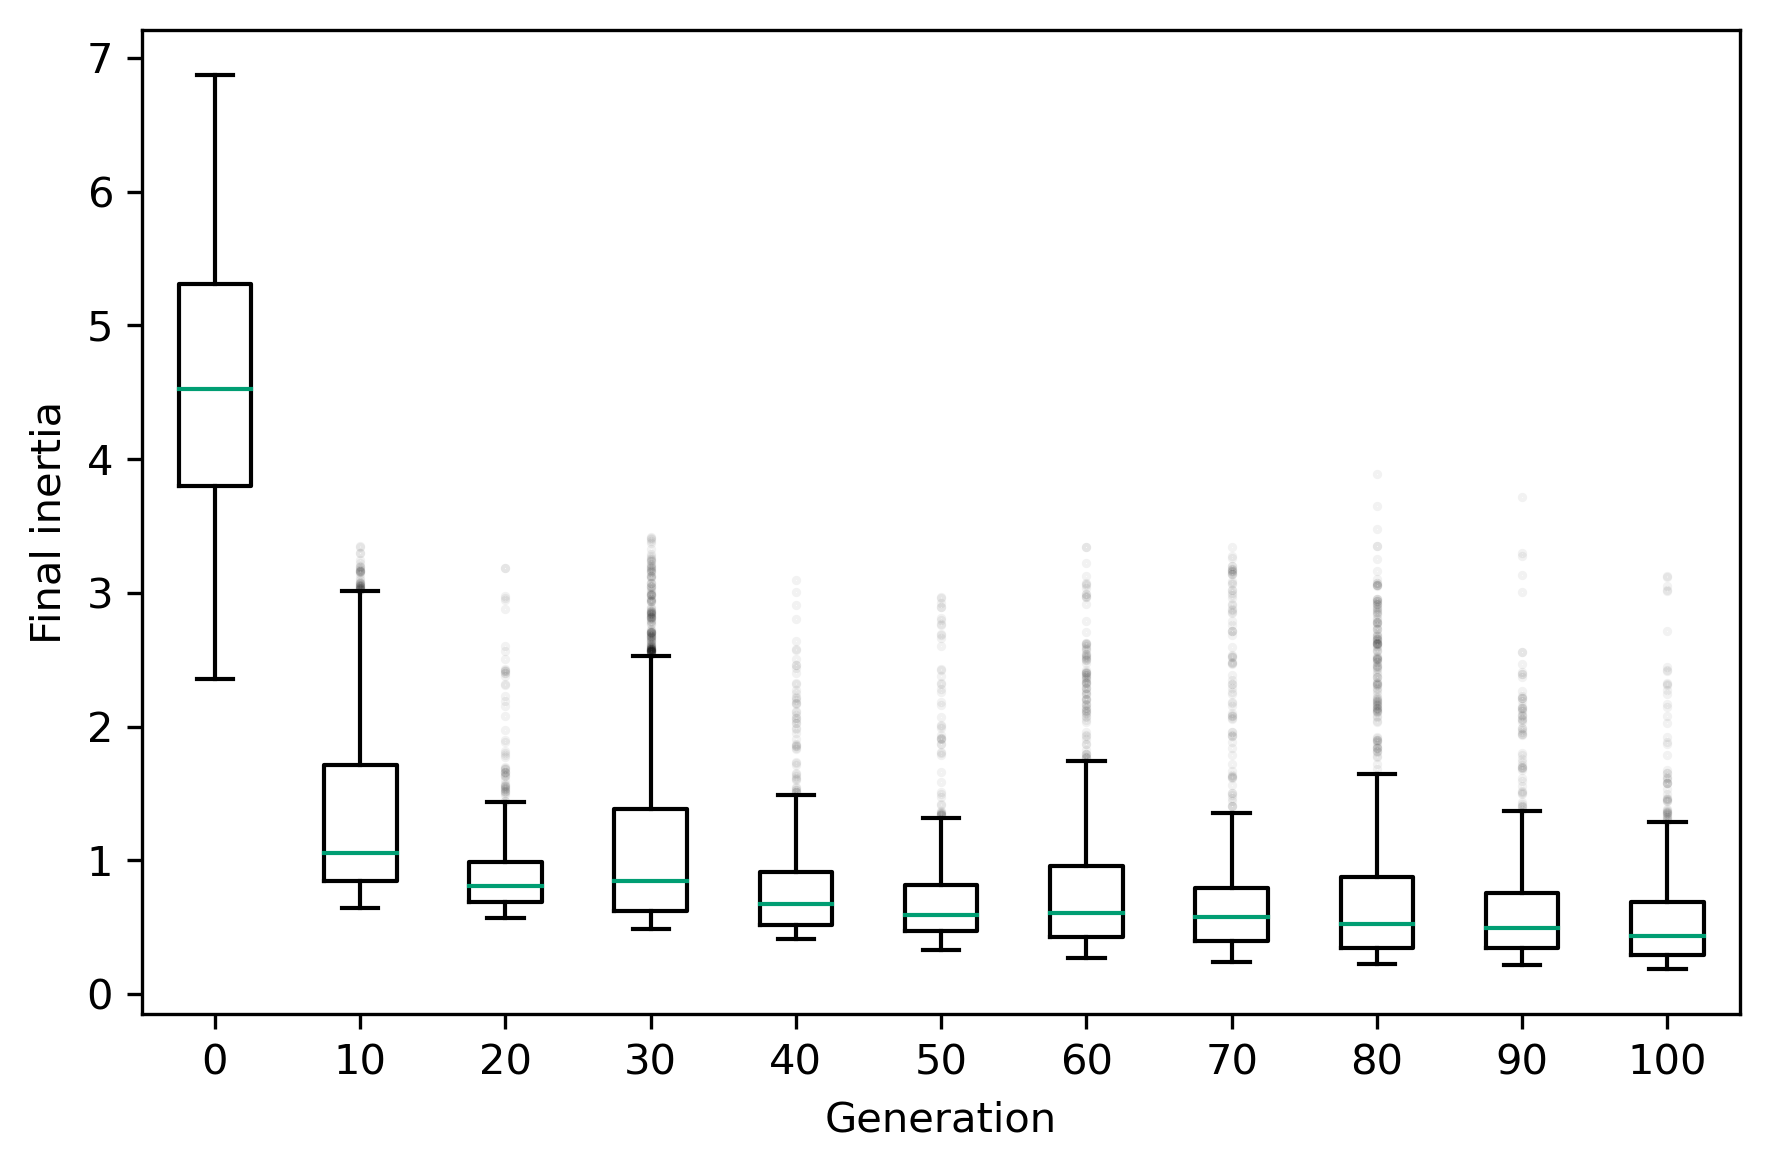

In [10]:
progression_boxplot(
    summary,
    "fitness",
    "Final inertia",
    epochs=epochs,
#     filename=name + "fitness.pdf",
)

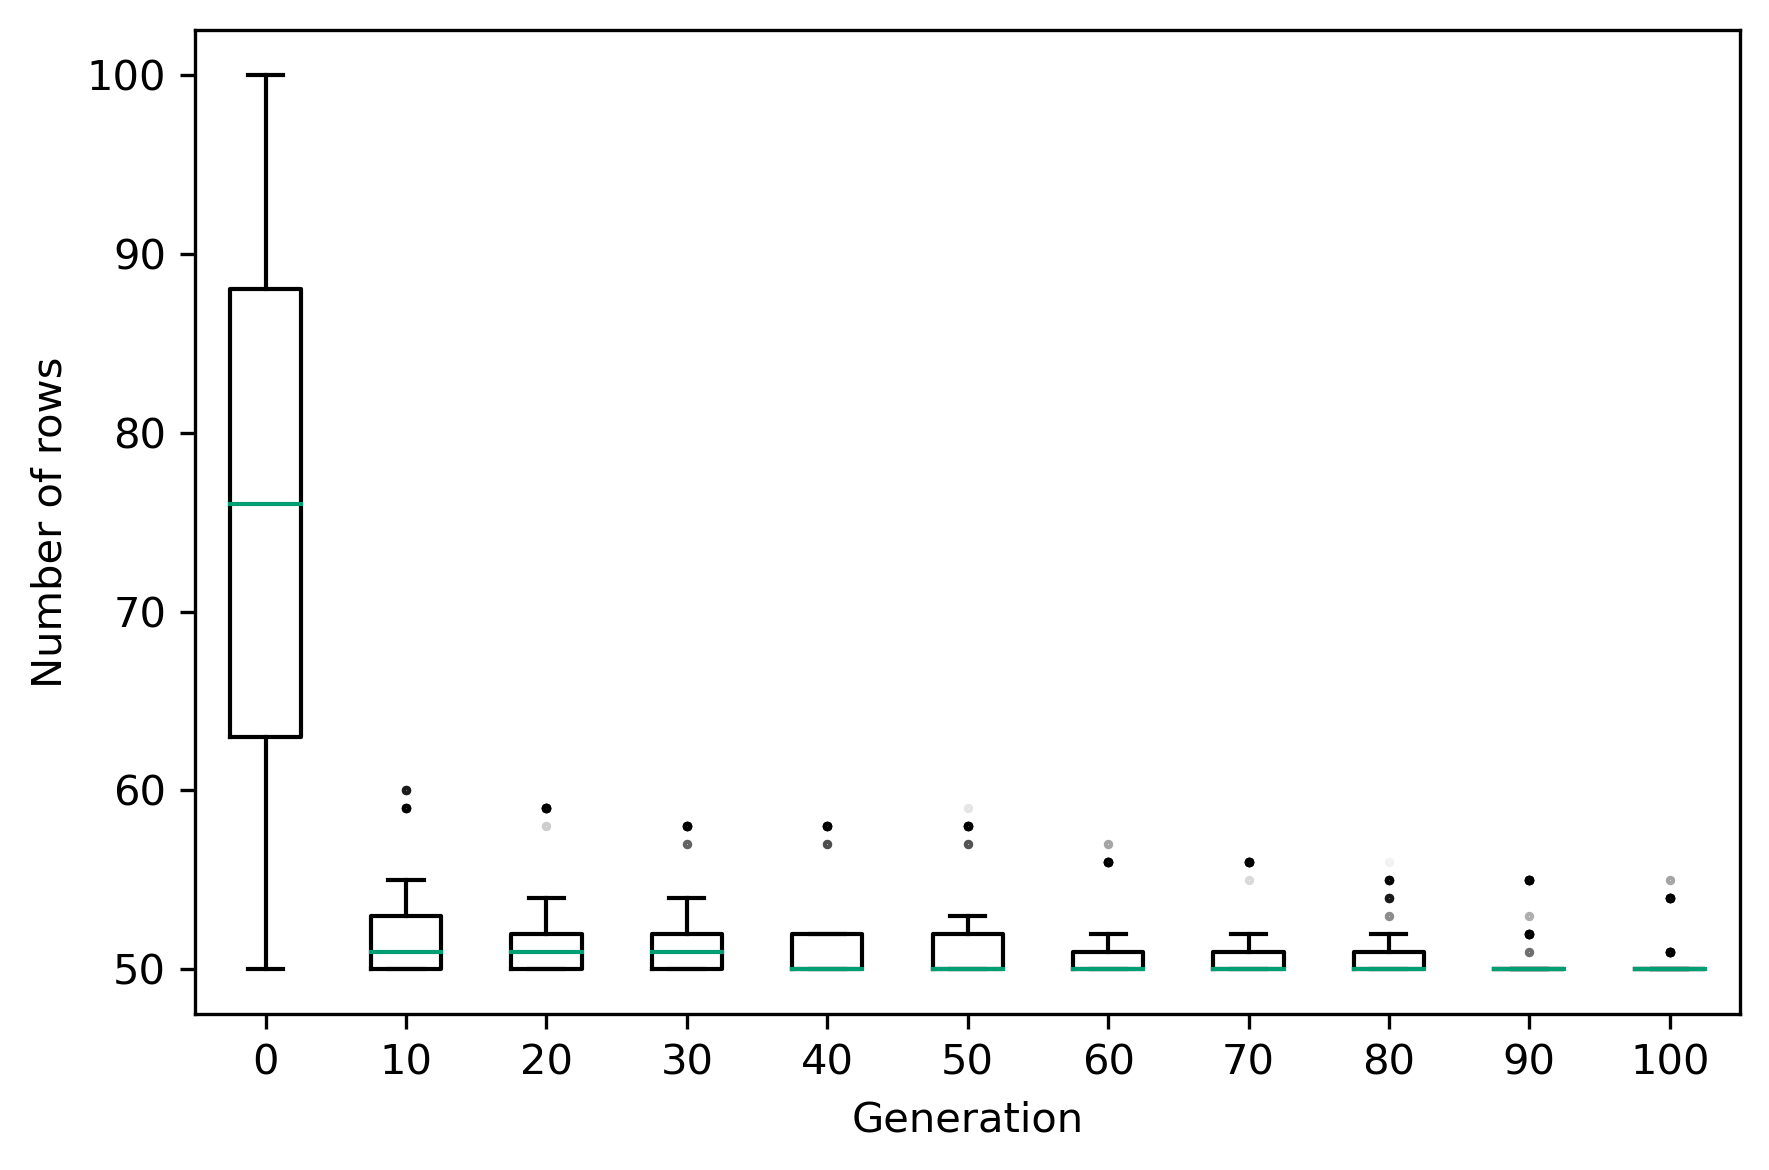

In [11]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs,# filename=name + "nrows.pdf"
)

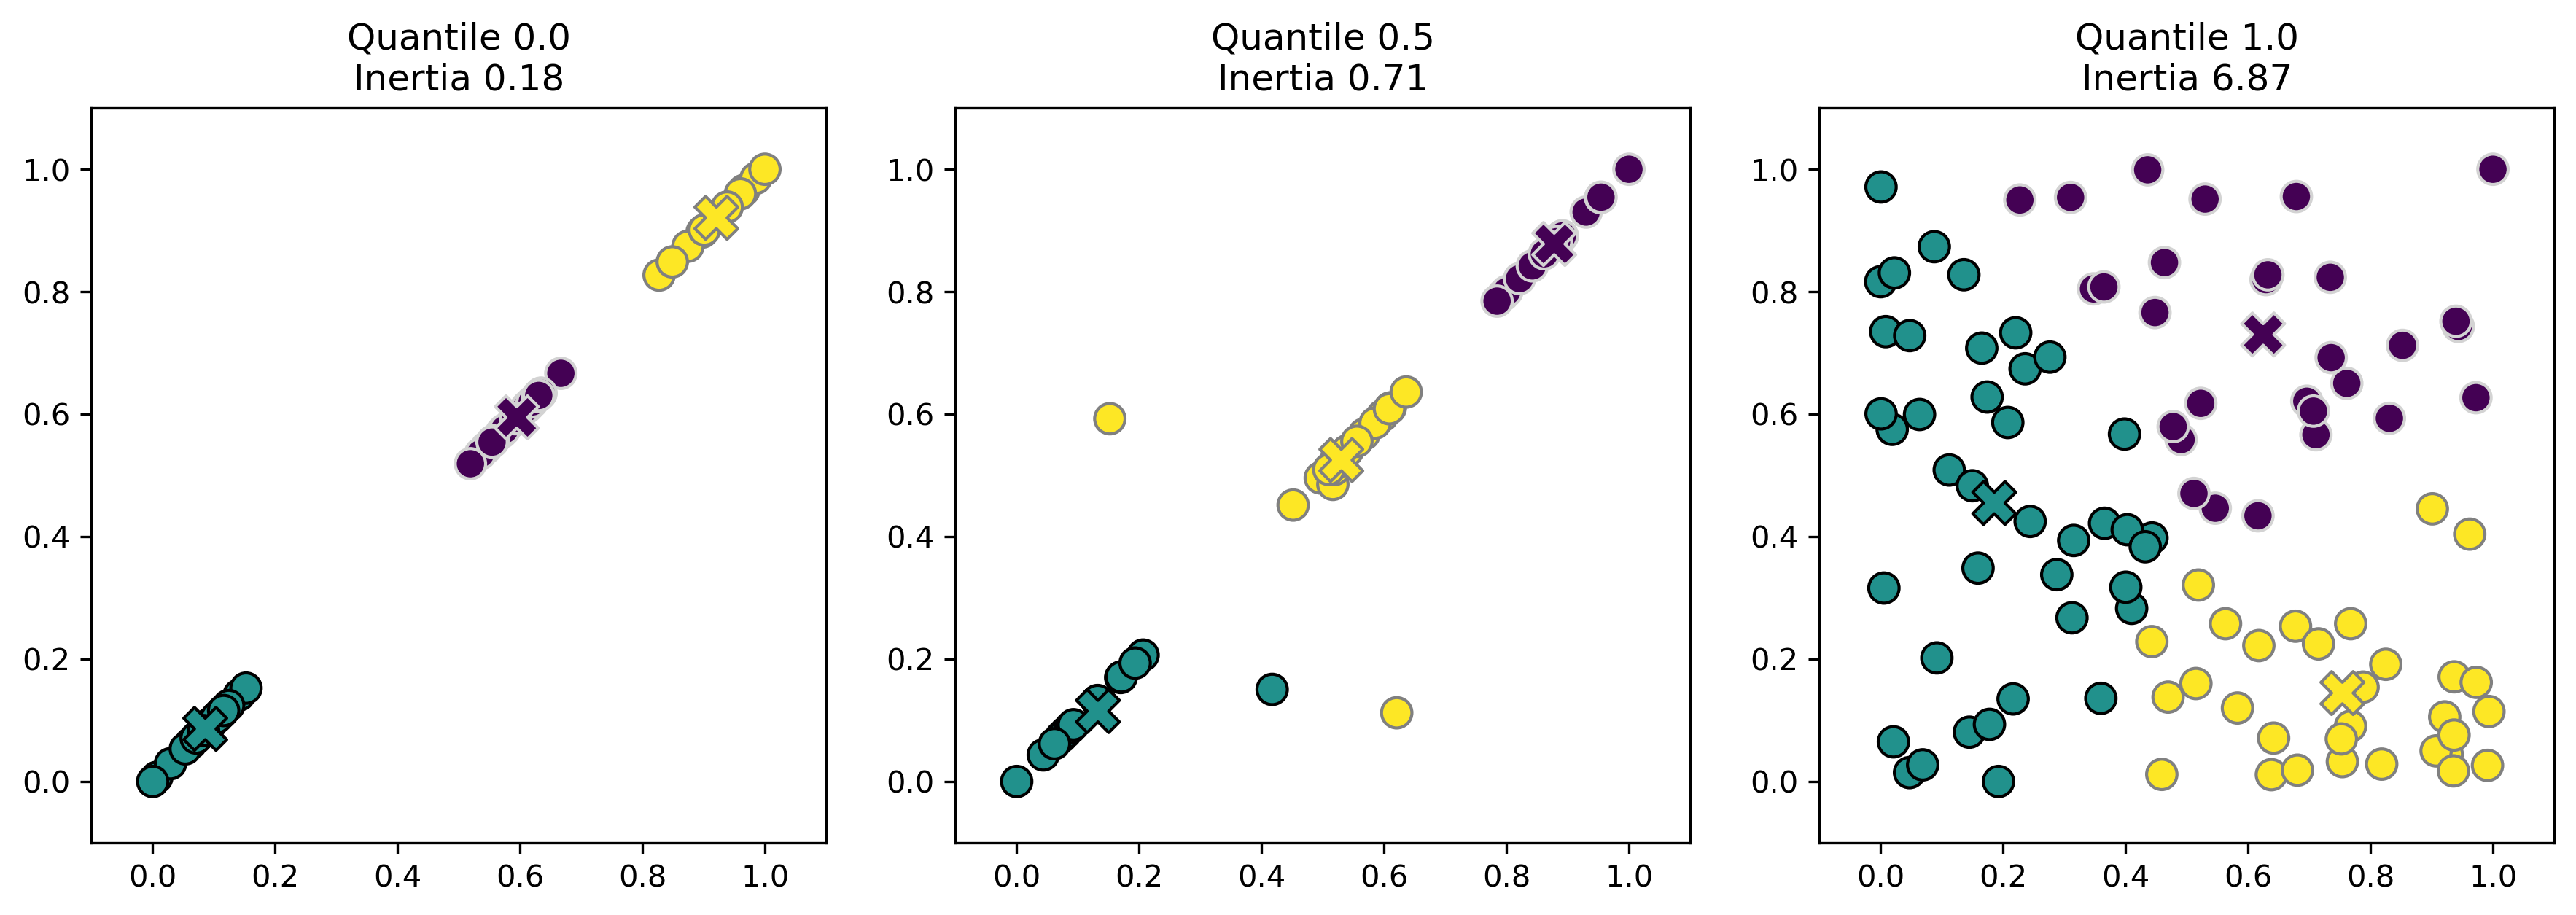

In [12]:
kmeans_individuals_scatterplot(out, inertia, ["inertia"])#, filename=name + "inds.pdf")

## k-means (silhouette)

In [13]:
out = DATA / "kmeans_silhouette" / "summary"
summary = pd.read_csv(out / "main.csv")

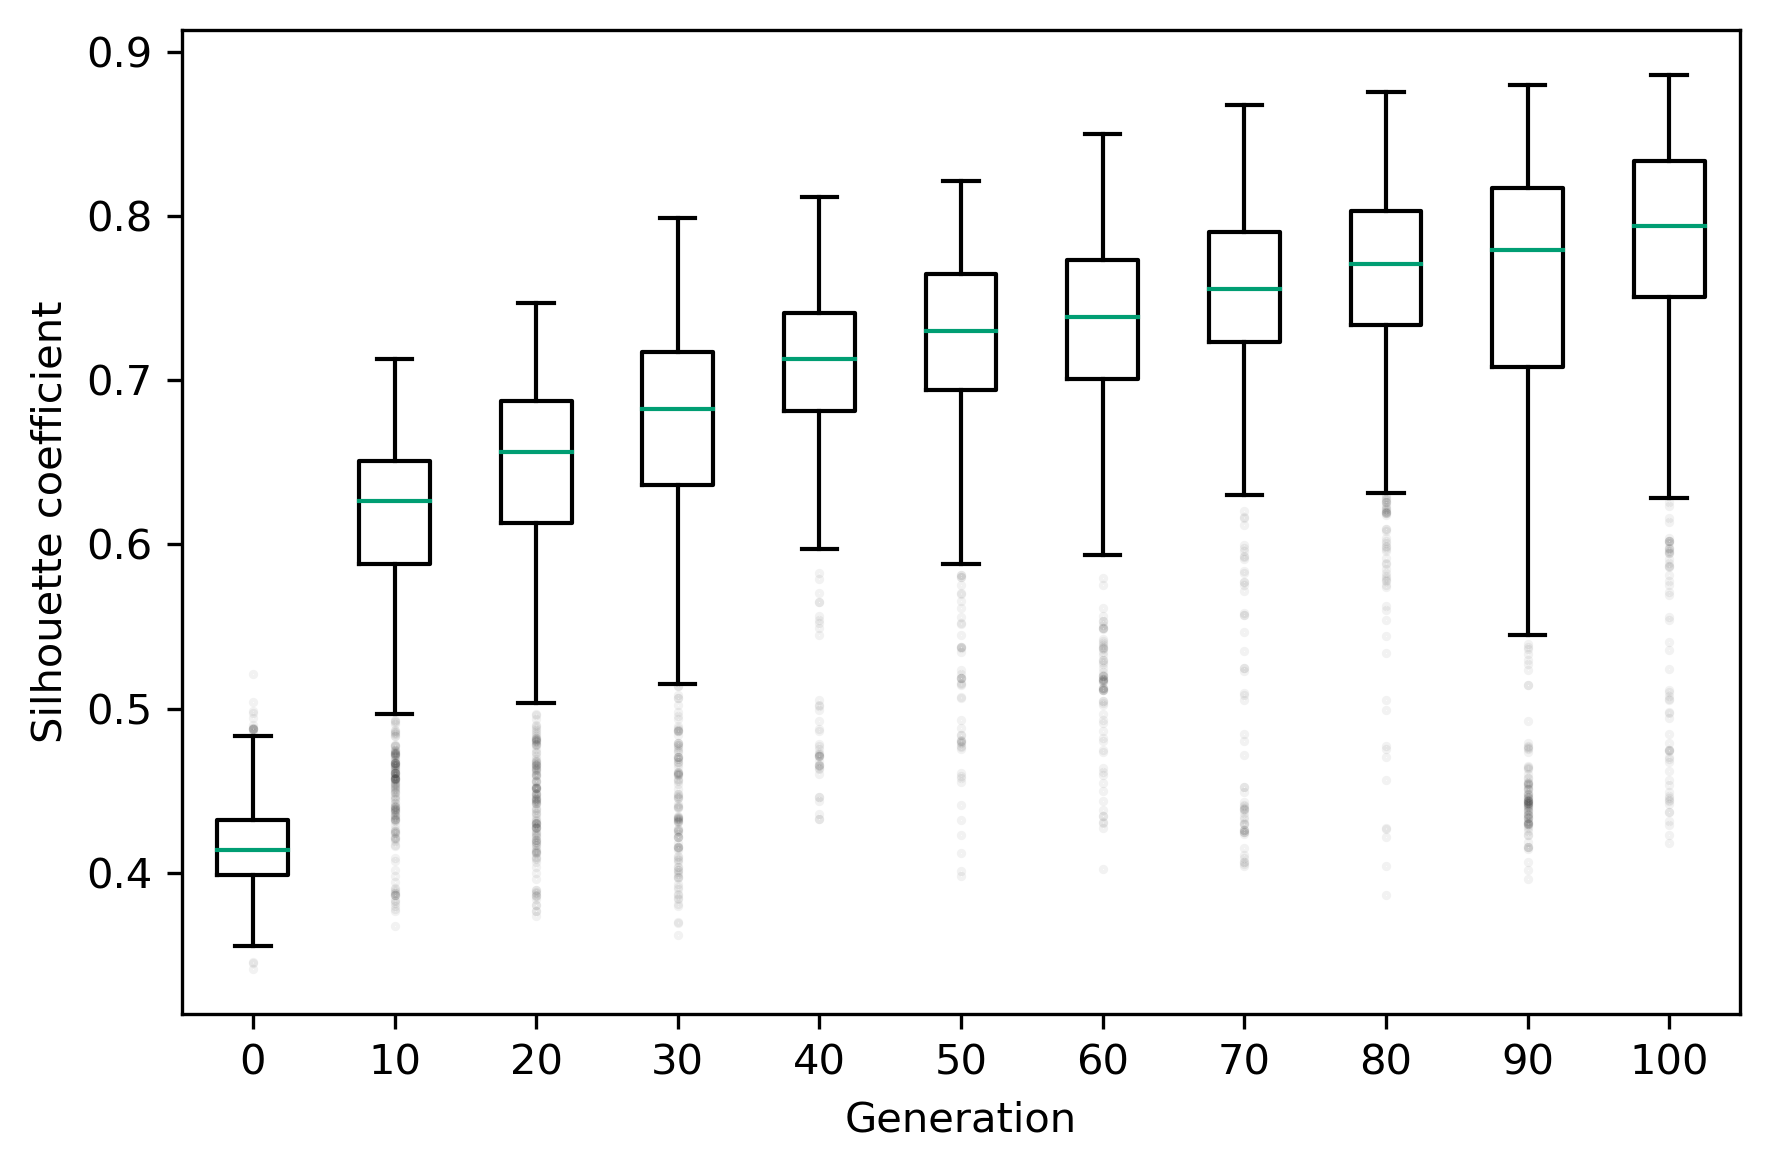

In [14]:
progression_boxplot(
    summary,
    "fitness",
    "Silhouette coefficient",
    epochs=epochs,
#     filename=name + "fitness.pdf",
)

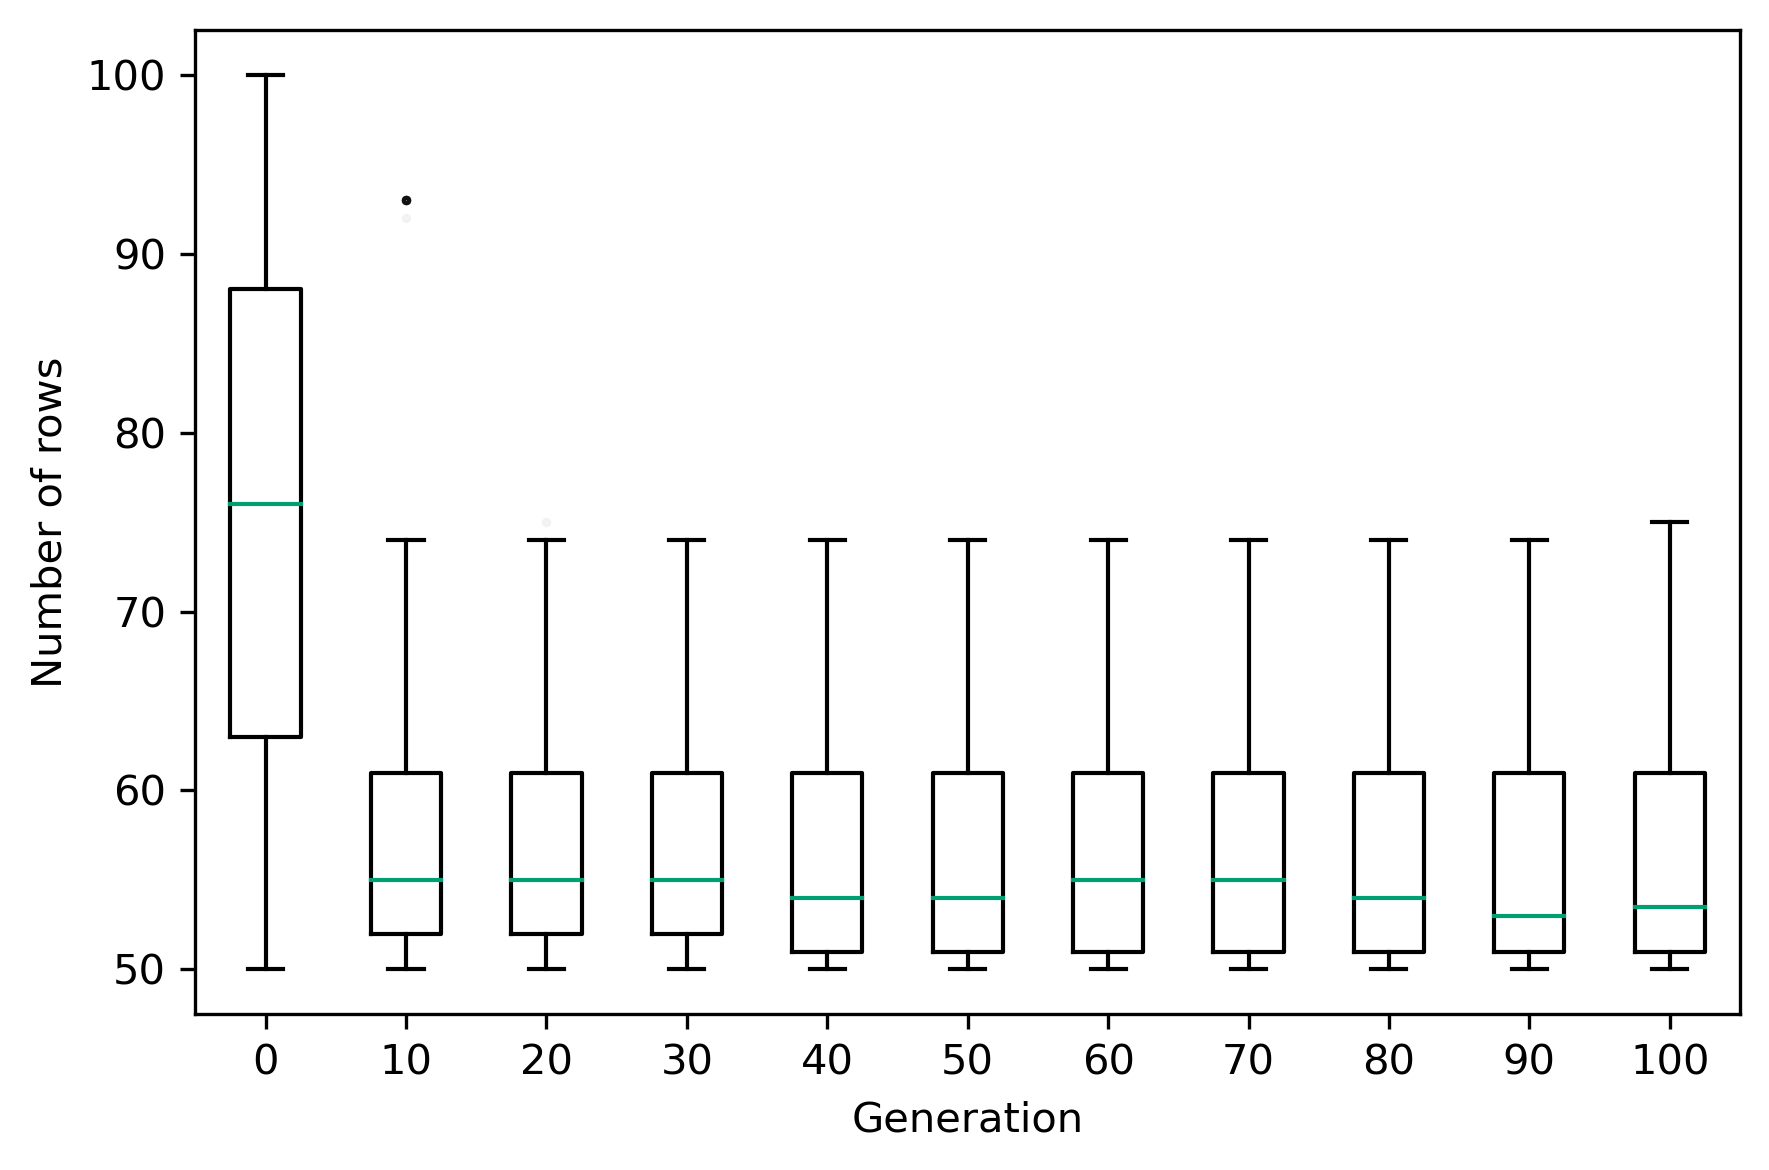

In [15]:
progression_boxplot(
    summary,
    "nrows",
    "Number of rows",
    epochs=epochs,
#     filename=name + "nrows.pdf"
)

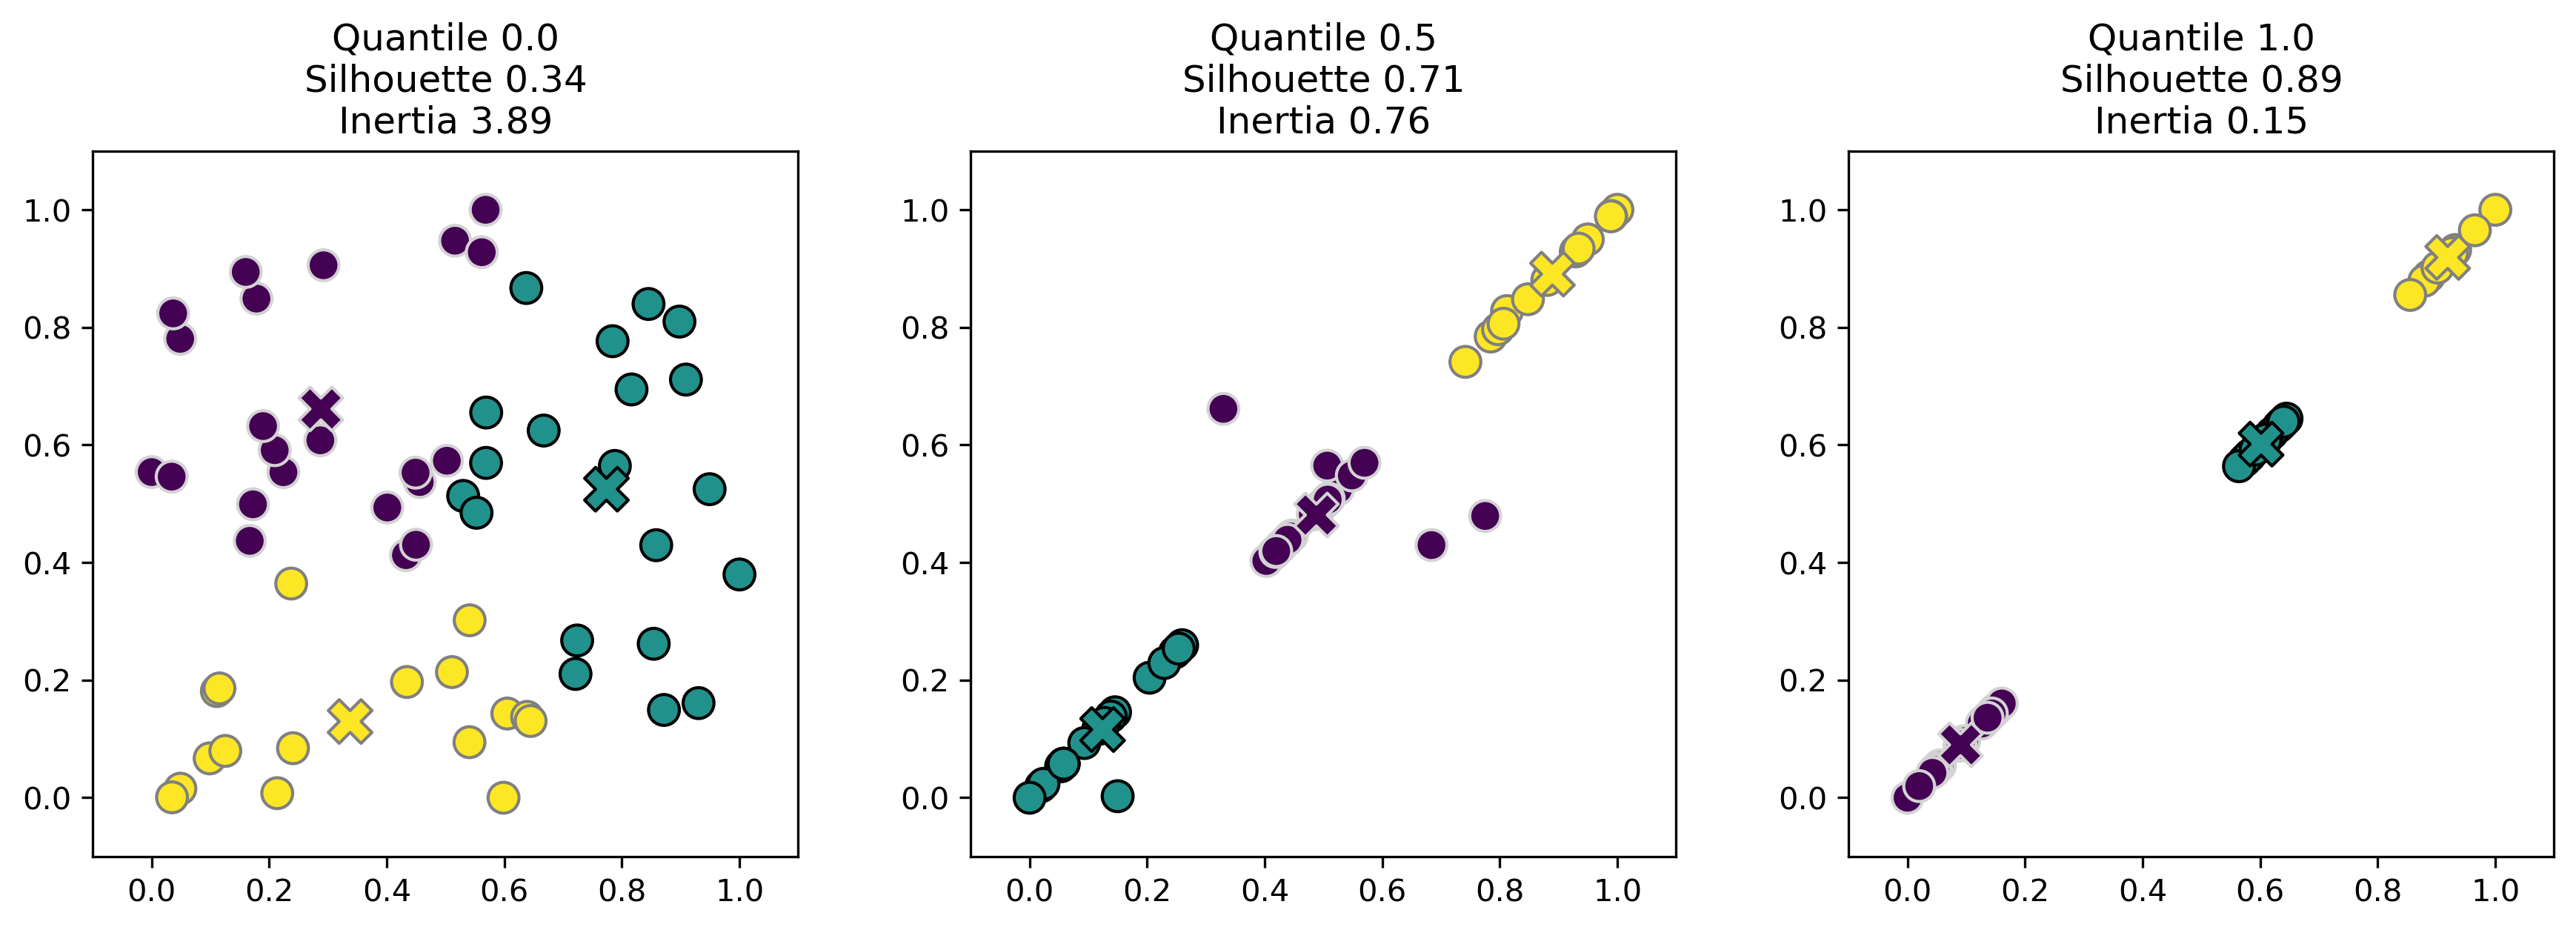

In [16]:
kmeans_individuals_scatterplot(out, silhouette, ["silhouette", "inertia"])

# k-means preferable over DBSCAN

In [17]:
out = DATA / "kmeans_preferable" / "summary"
summary = pd.read_csv(out / "main.csv")
summary["fitness"] = summary["fitness"].replace({-3: - np.infty})

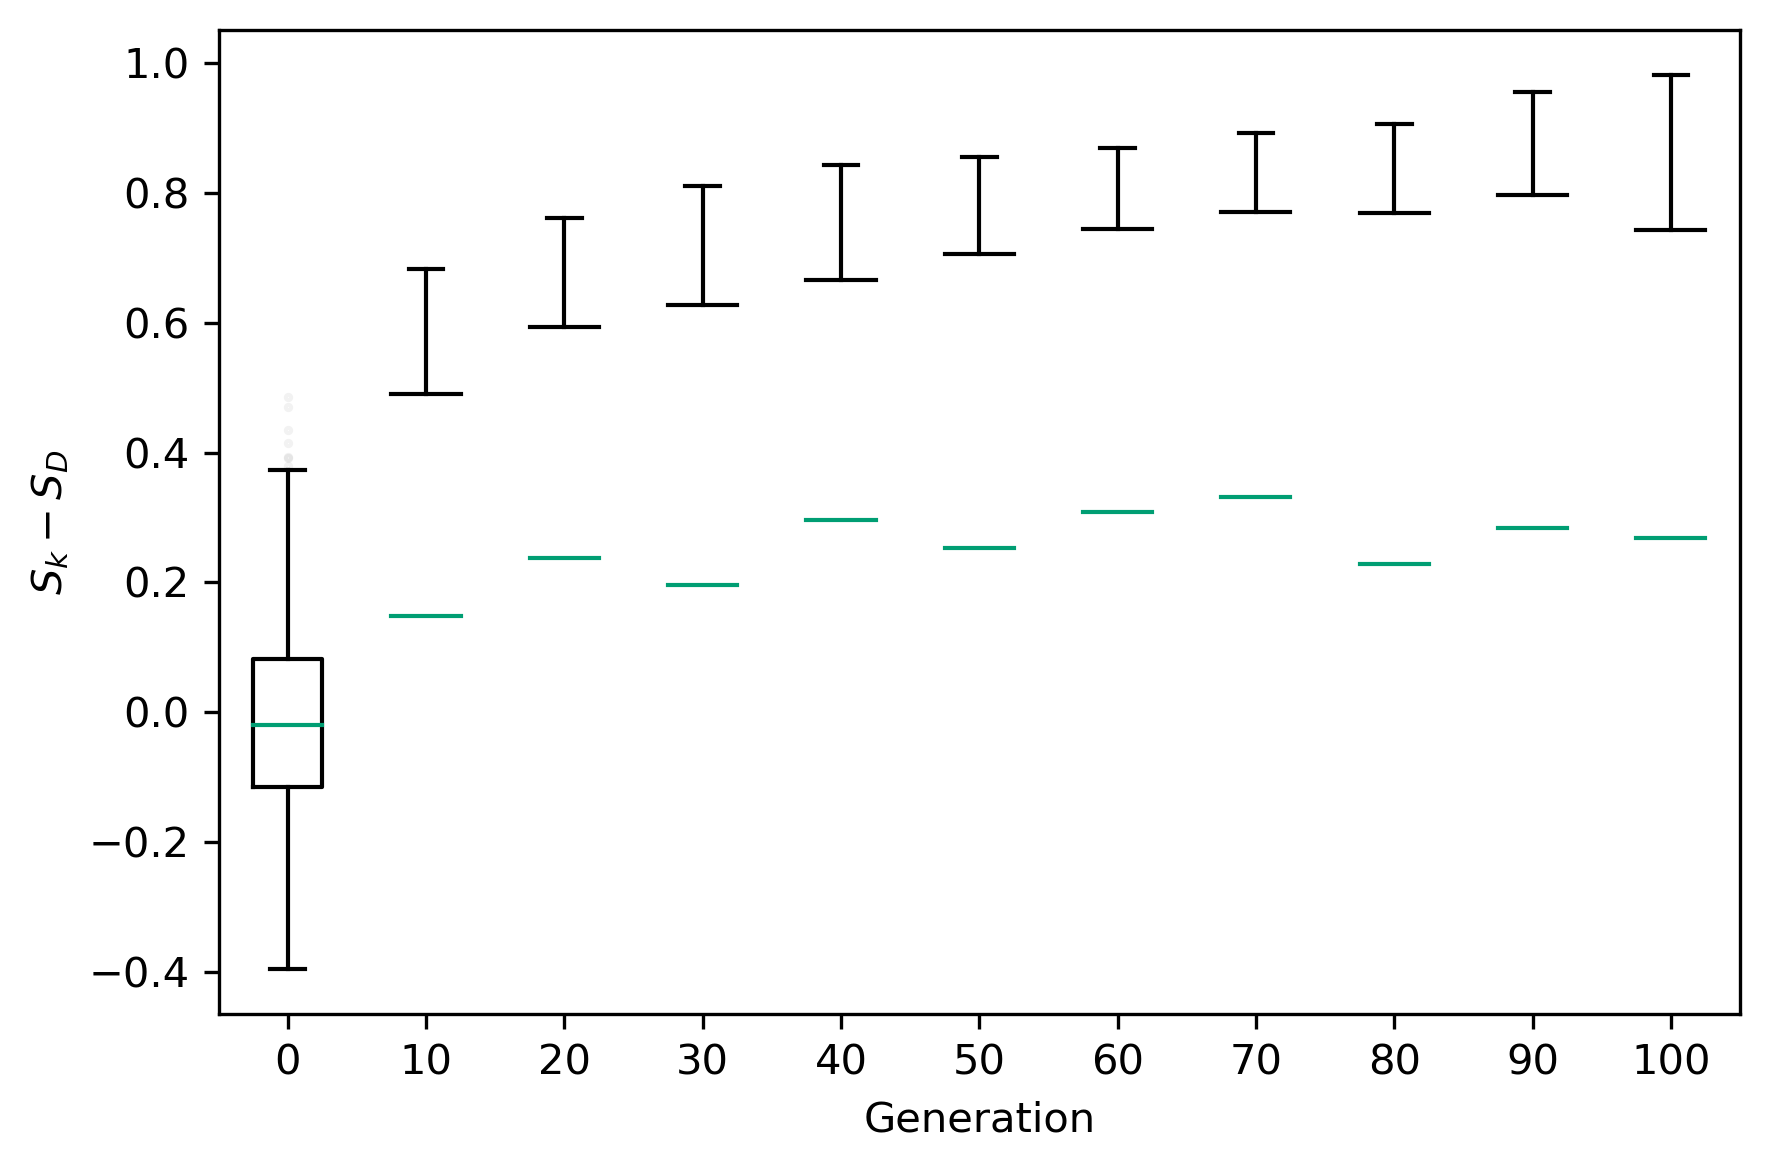

In [18]:
progression_boxplot(
    summary,
    "fitness",
    "$S_k - S_D$",
    epochs=epochs,
    #filename=name + "fitness.pdf"
)

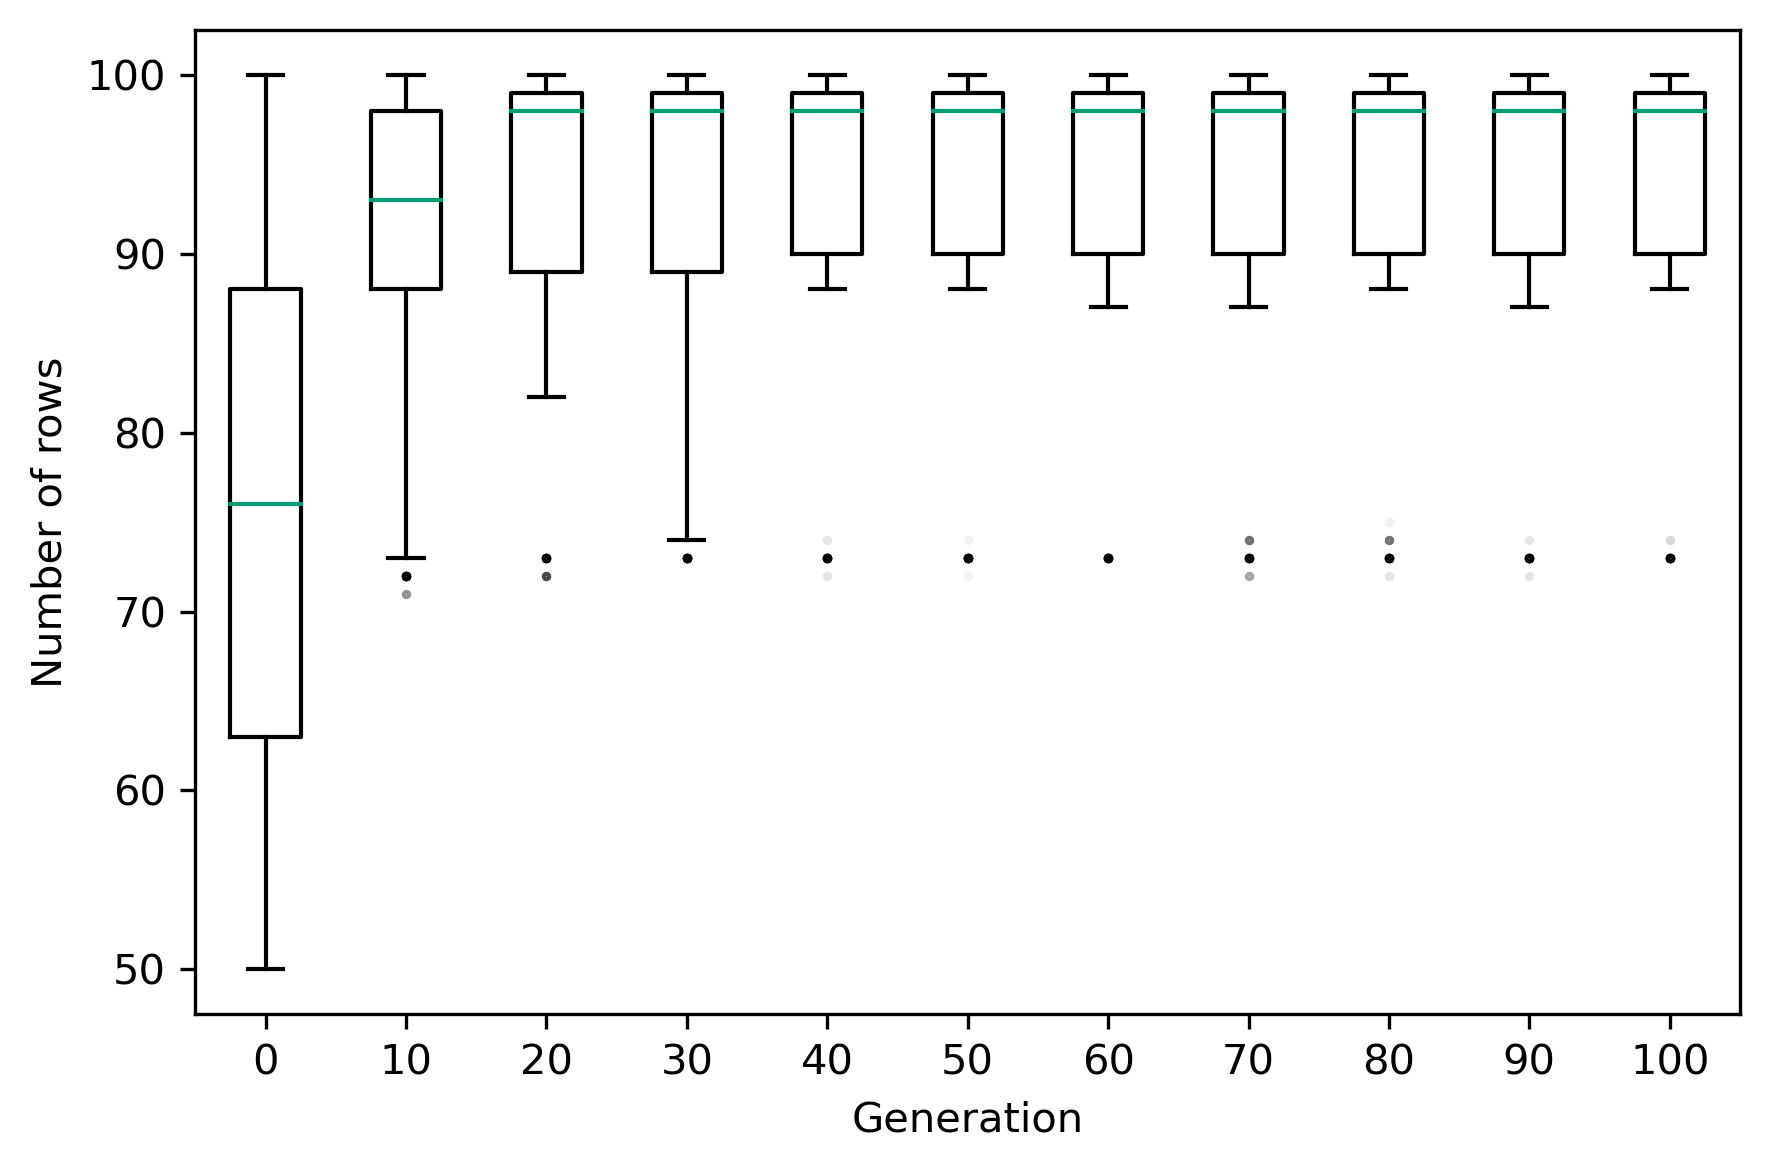

In [19]:
progression_boxplot(
    summary,
    "nrows",
    "Number of rows",
    epochs=epochs,
#     filename=name + "nrows.pdf"
)

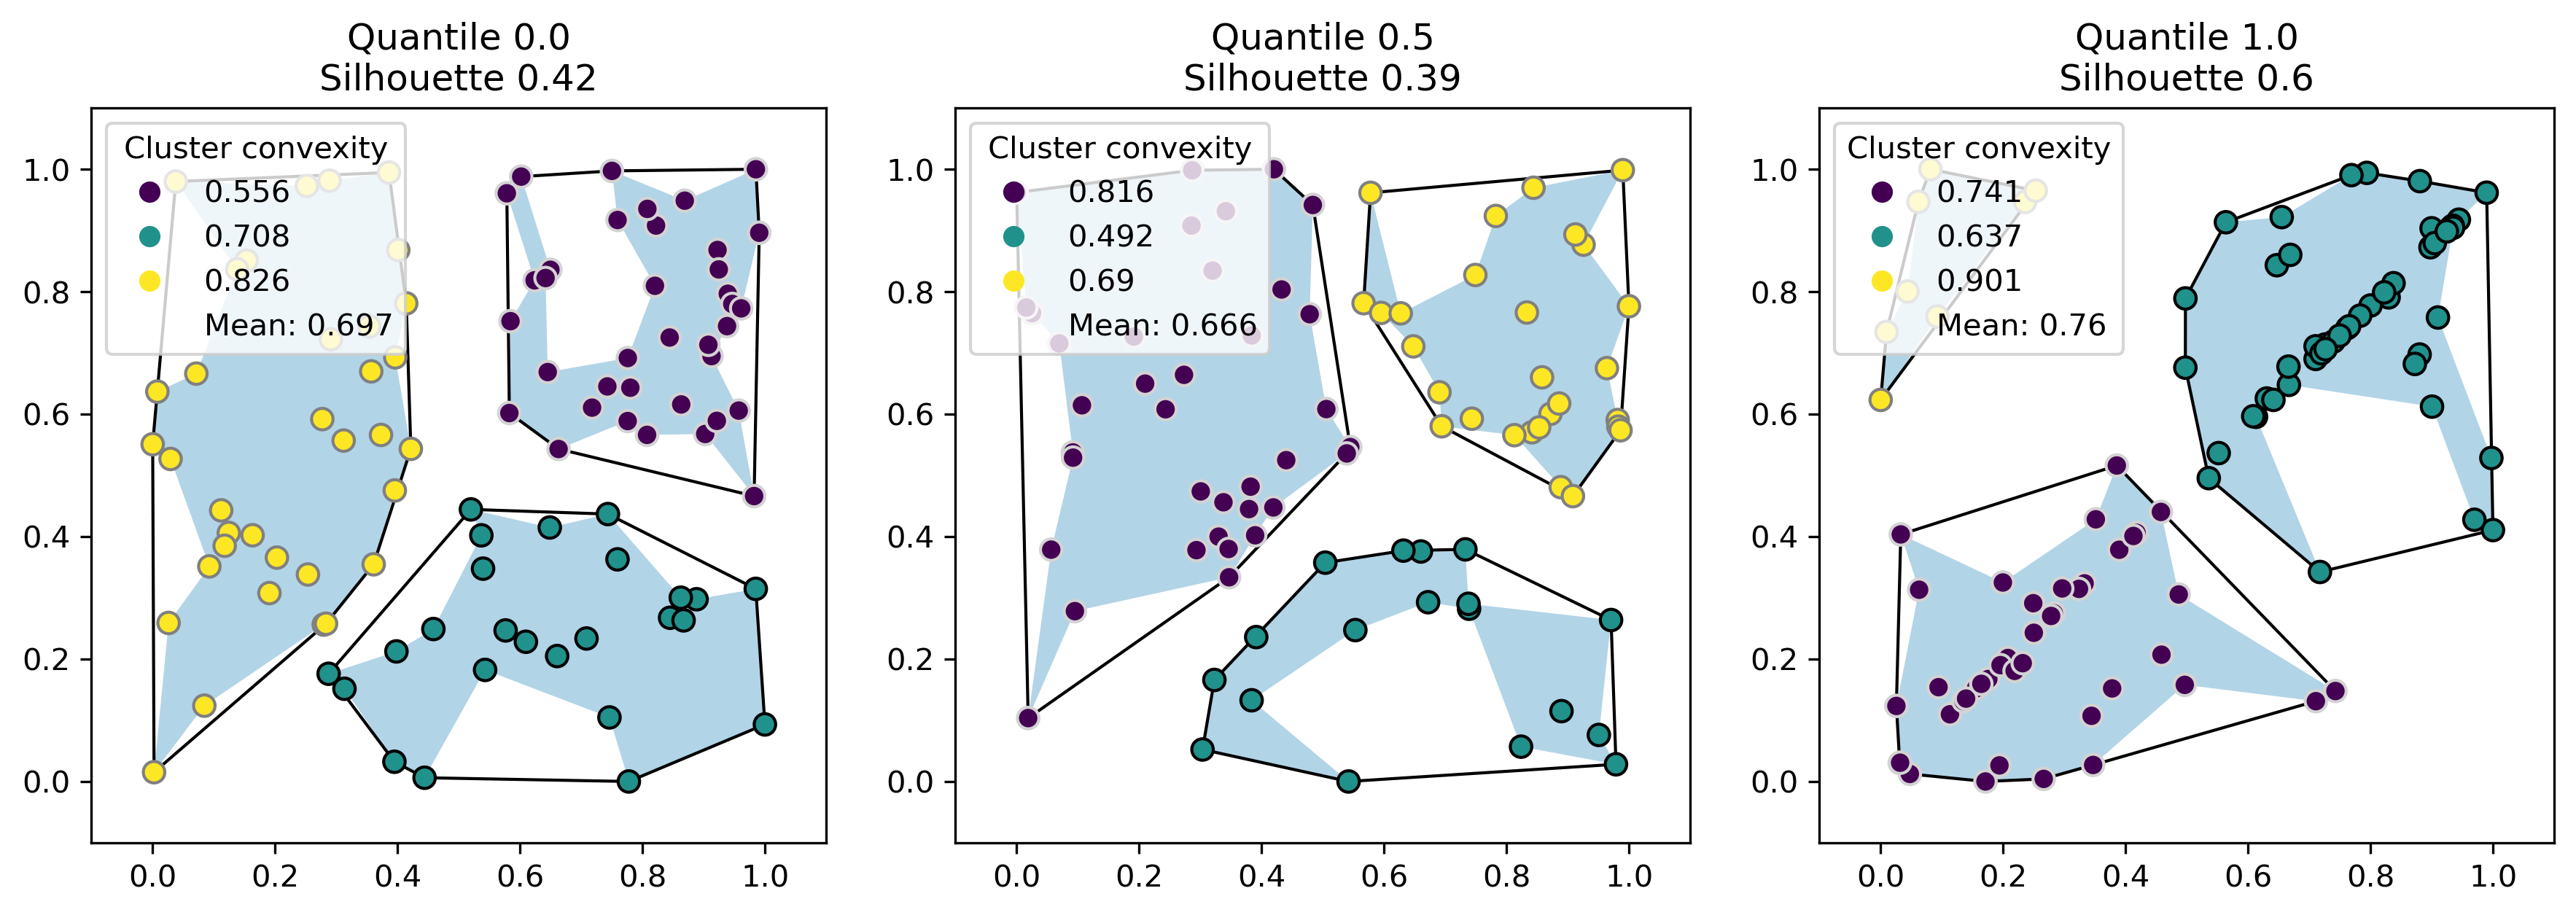

In [20]:
convexity_scatterplot(
    out,
    "kmeans",
    #filename=name + "kmeans_inds.pdf"
)

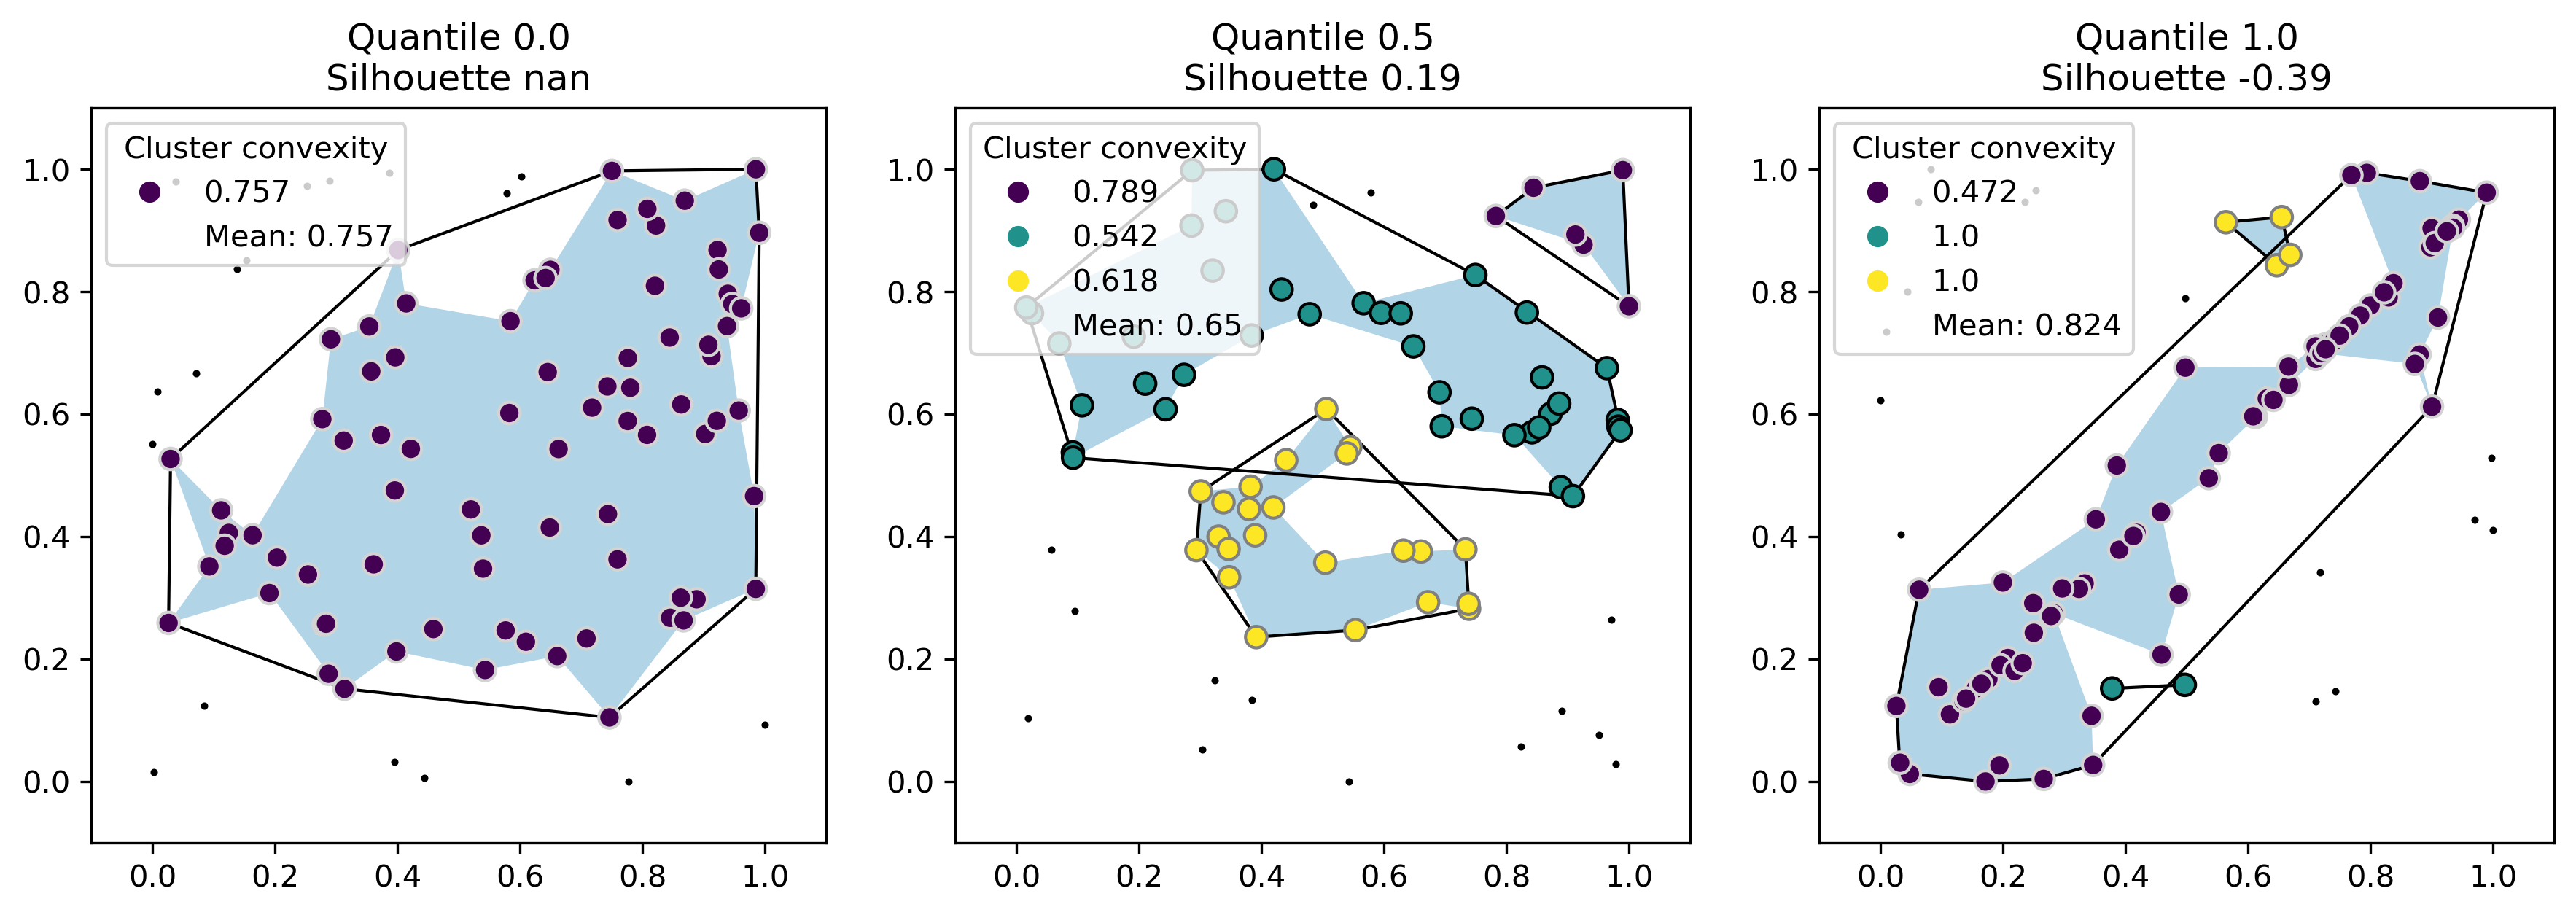

In [21]:
convexity_scatterplot(
    out,
    "dbscan",
    #filename=name + "kmeans_inds.pdf"
)

## DBSCAN preferable over $k$-means

In [22]:
out = DATA / "dbscan_preferable" / "summary"
summary = pd.read_csv(out / "main.csv")
summary["fitness"] = summary["fitness"].replace({-3: -np.infty})

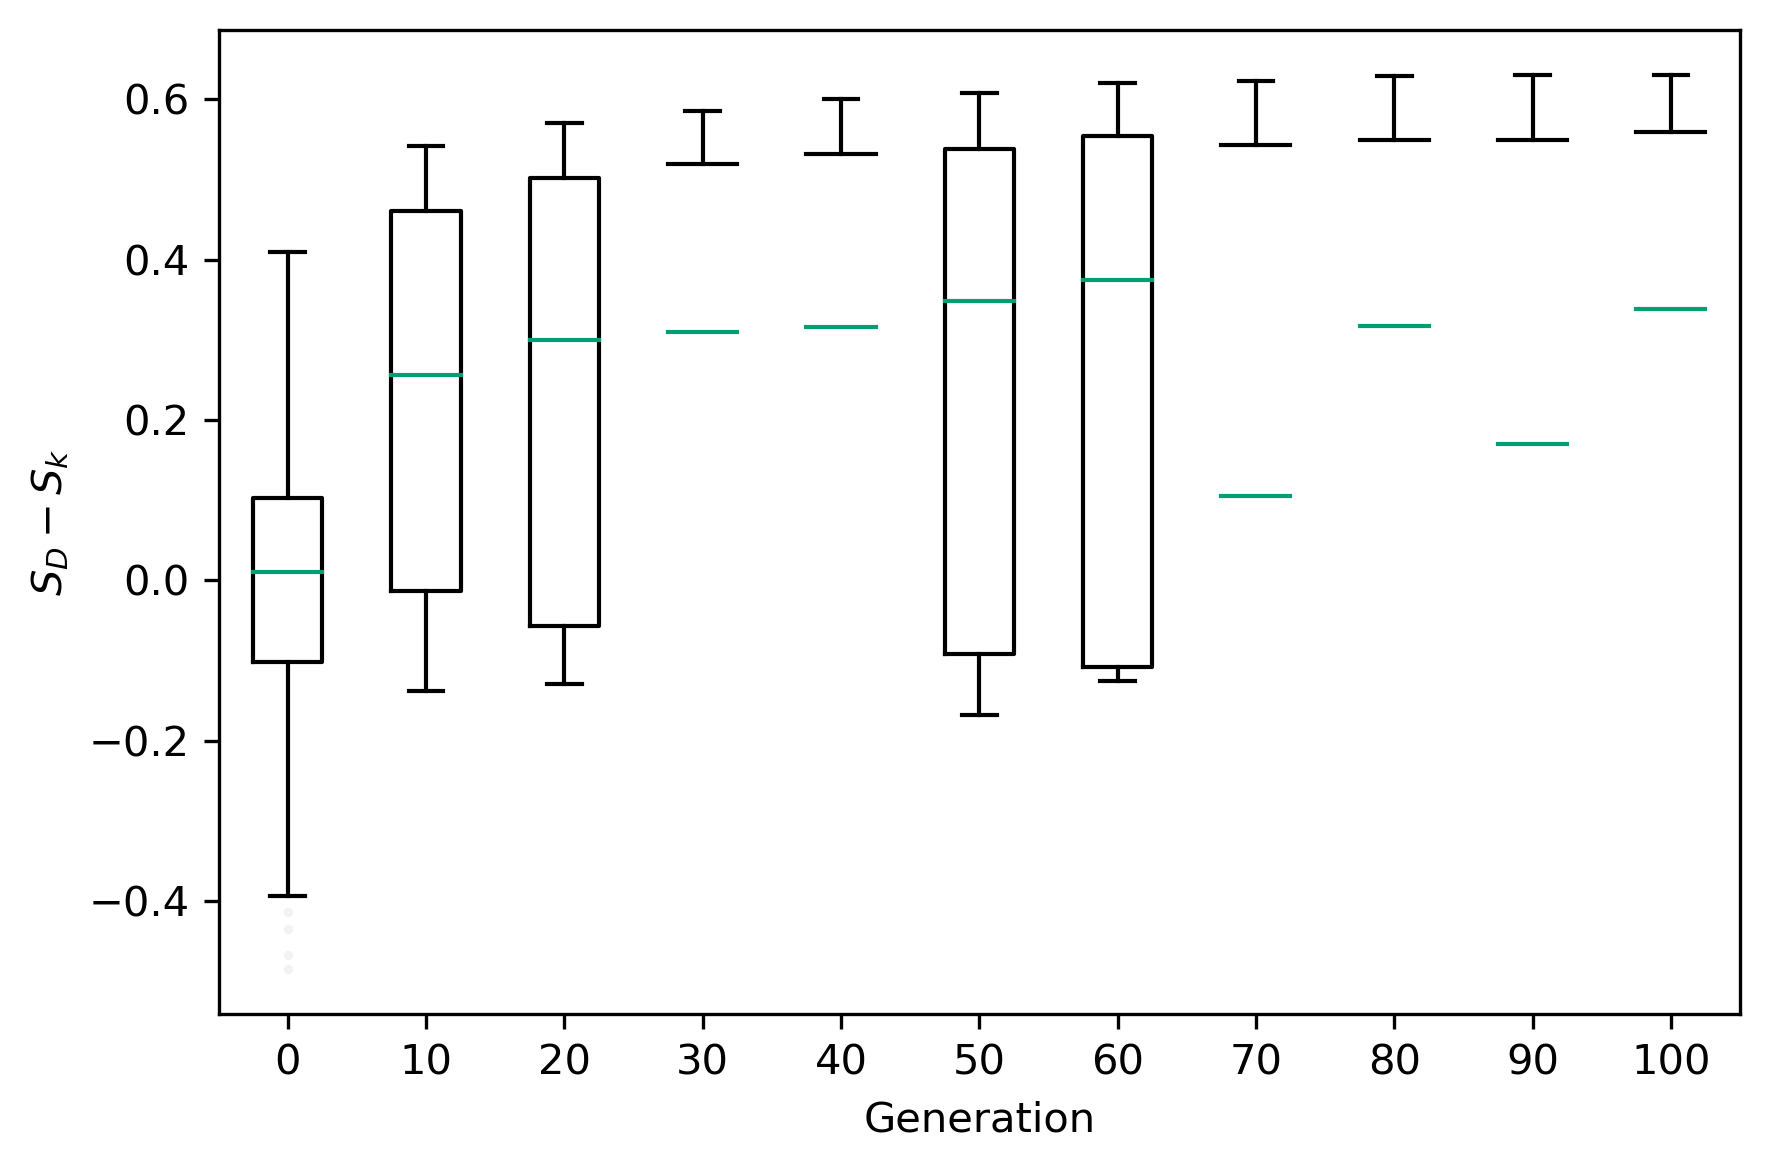

In [23]:
progression_boxplot(
    summary,
    "fitness",
    "$S_D - S_k$",
    epochs=epochs,
#     filename=name + "fitness.pdf",
)

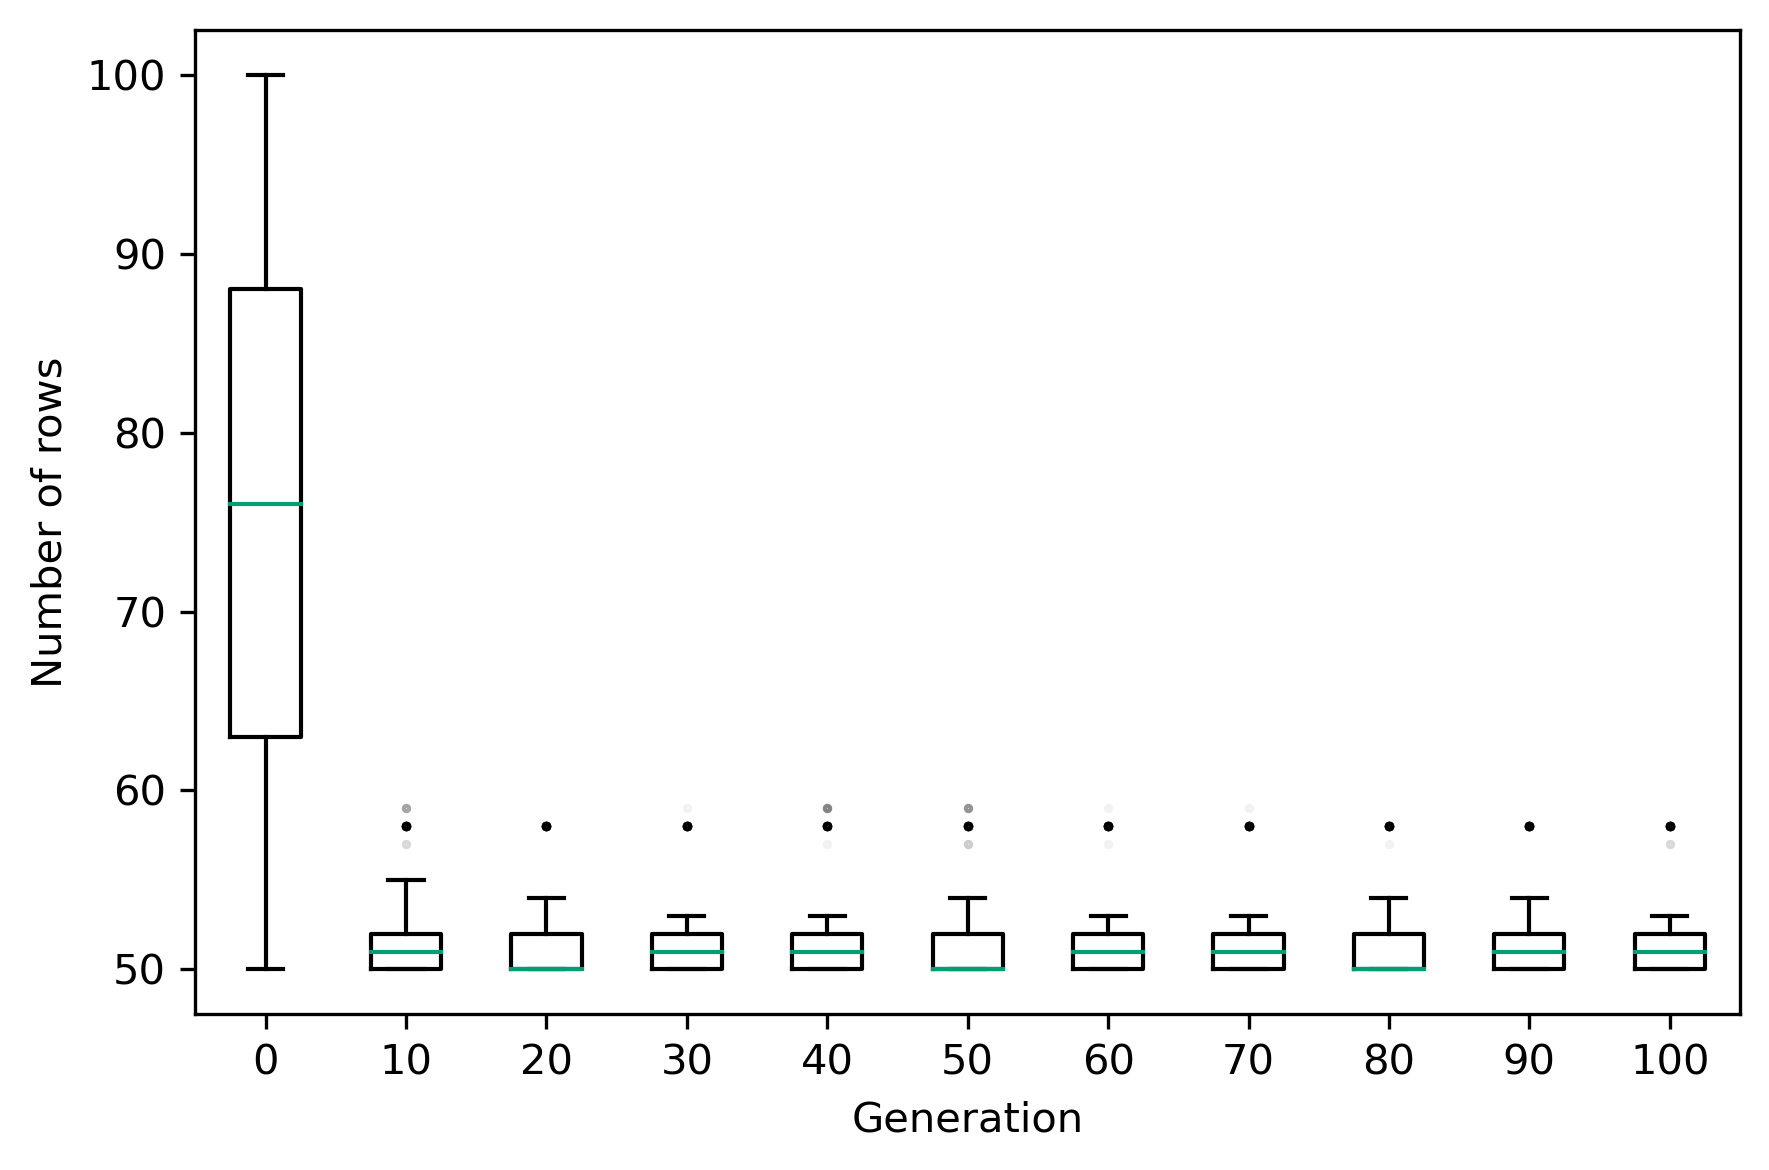

In [24]:
progression_boxplot(
    summary,
    "nrows",
    "Number of rows",
    epochs=epochs,
#     filename=name + "nrows.pdf",
)

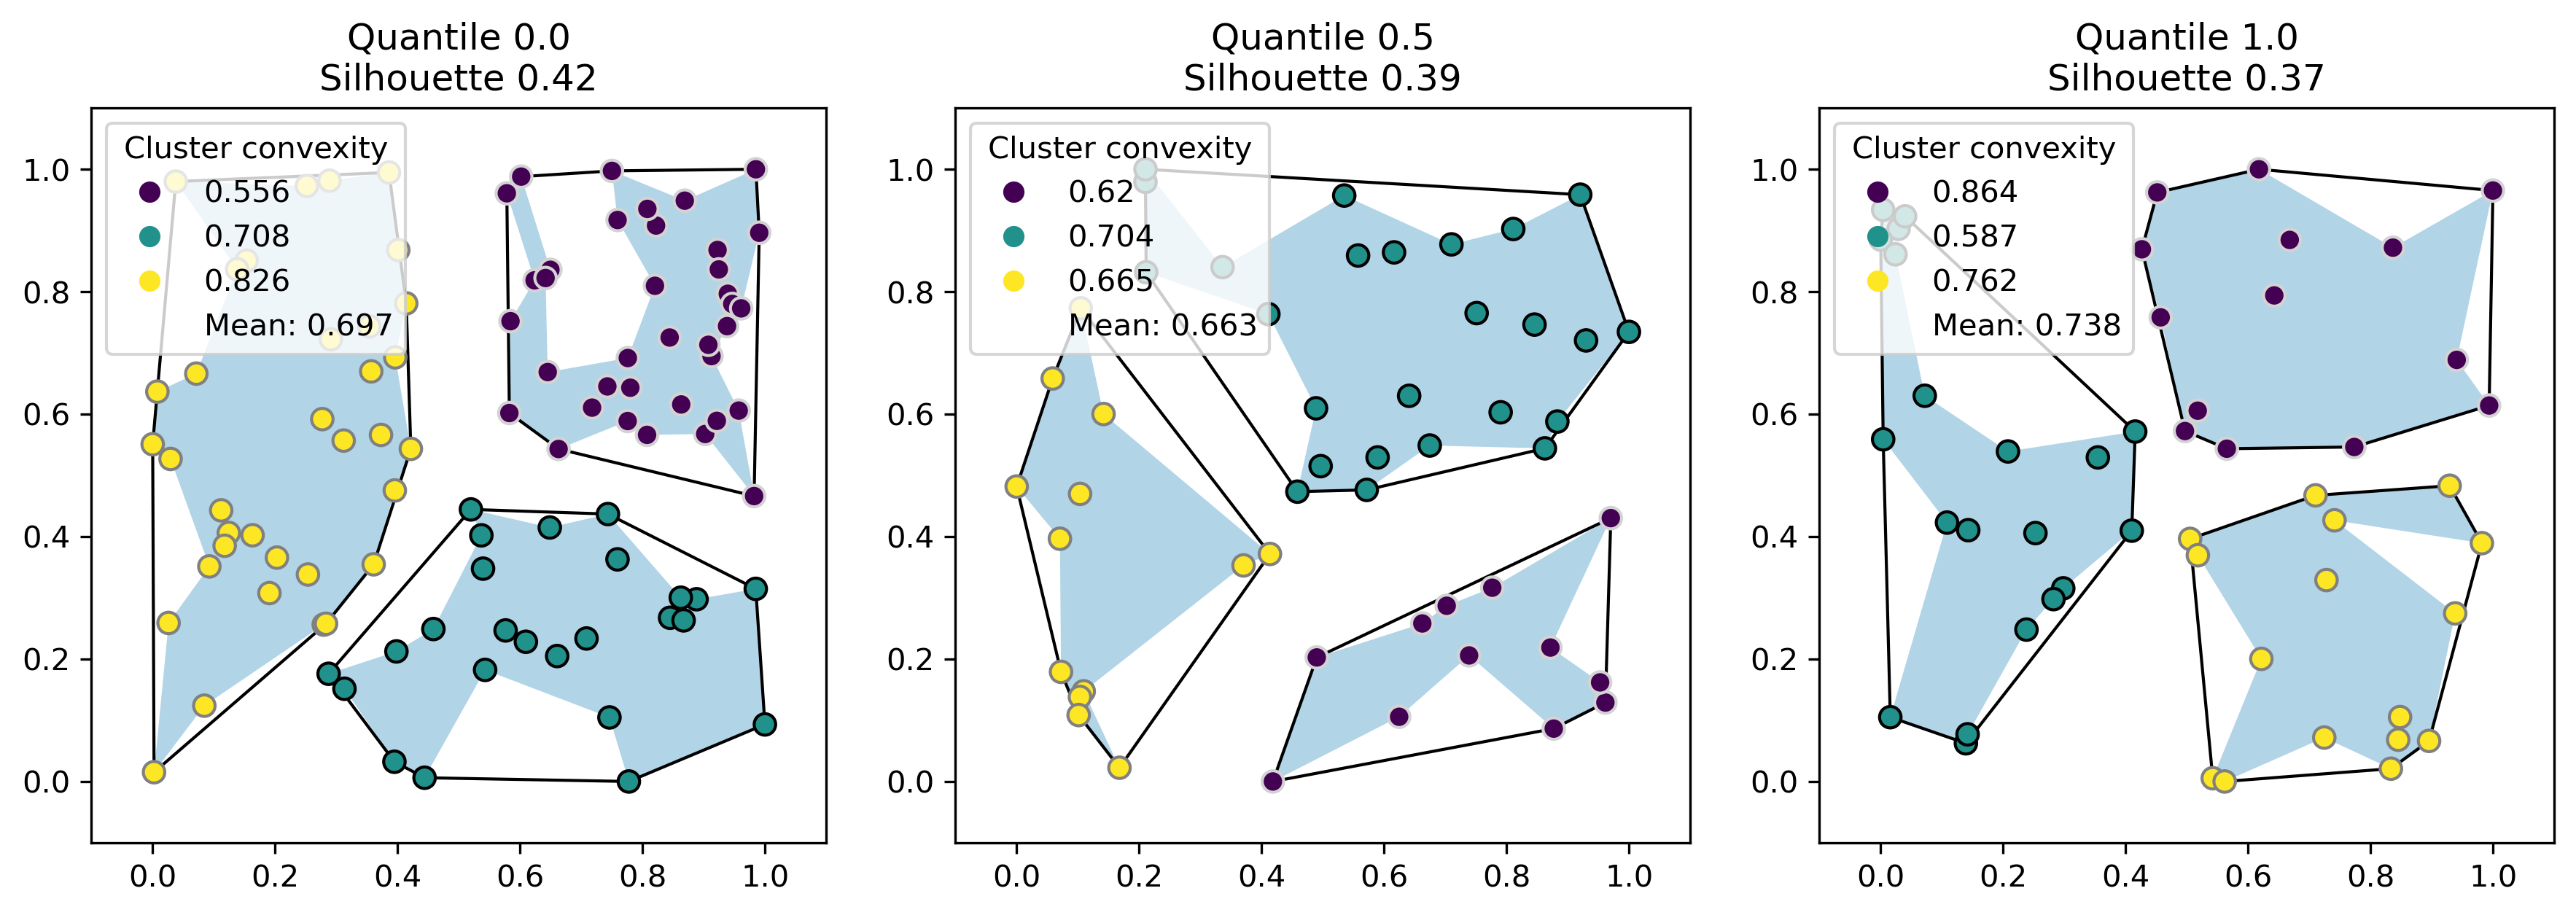

In [25]:
convexity_scatterplot(
    out,
    "kmeans",
#     filename=name + "kmeans_inds.pdf"
)

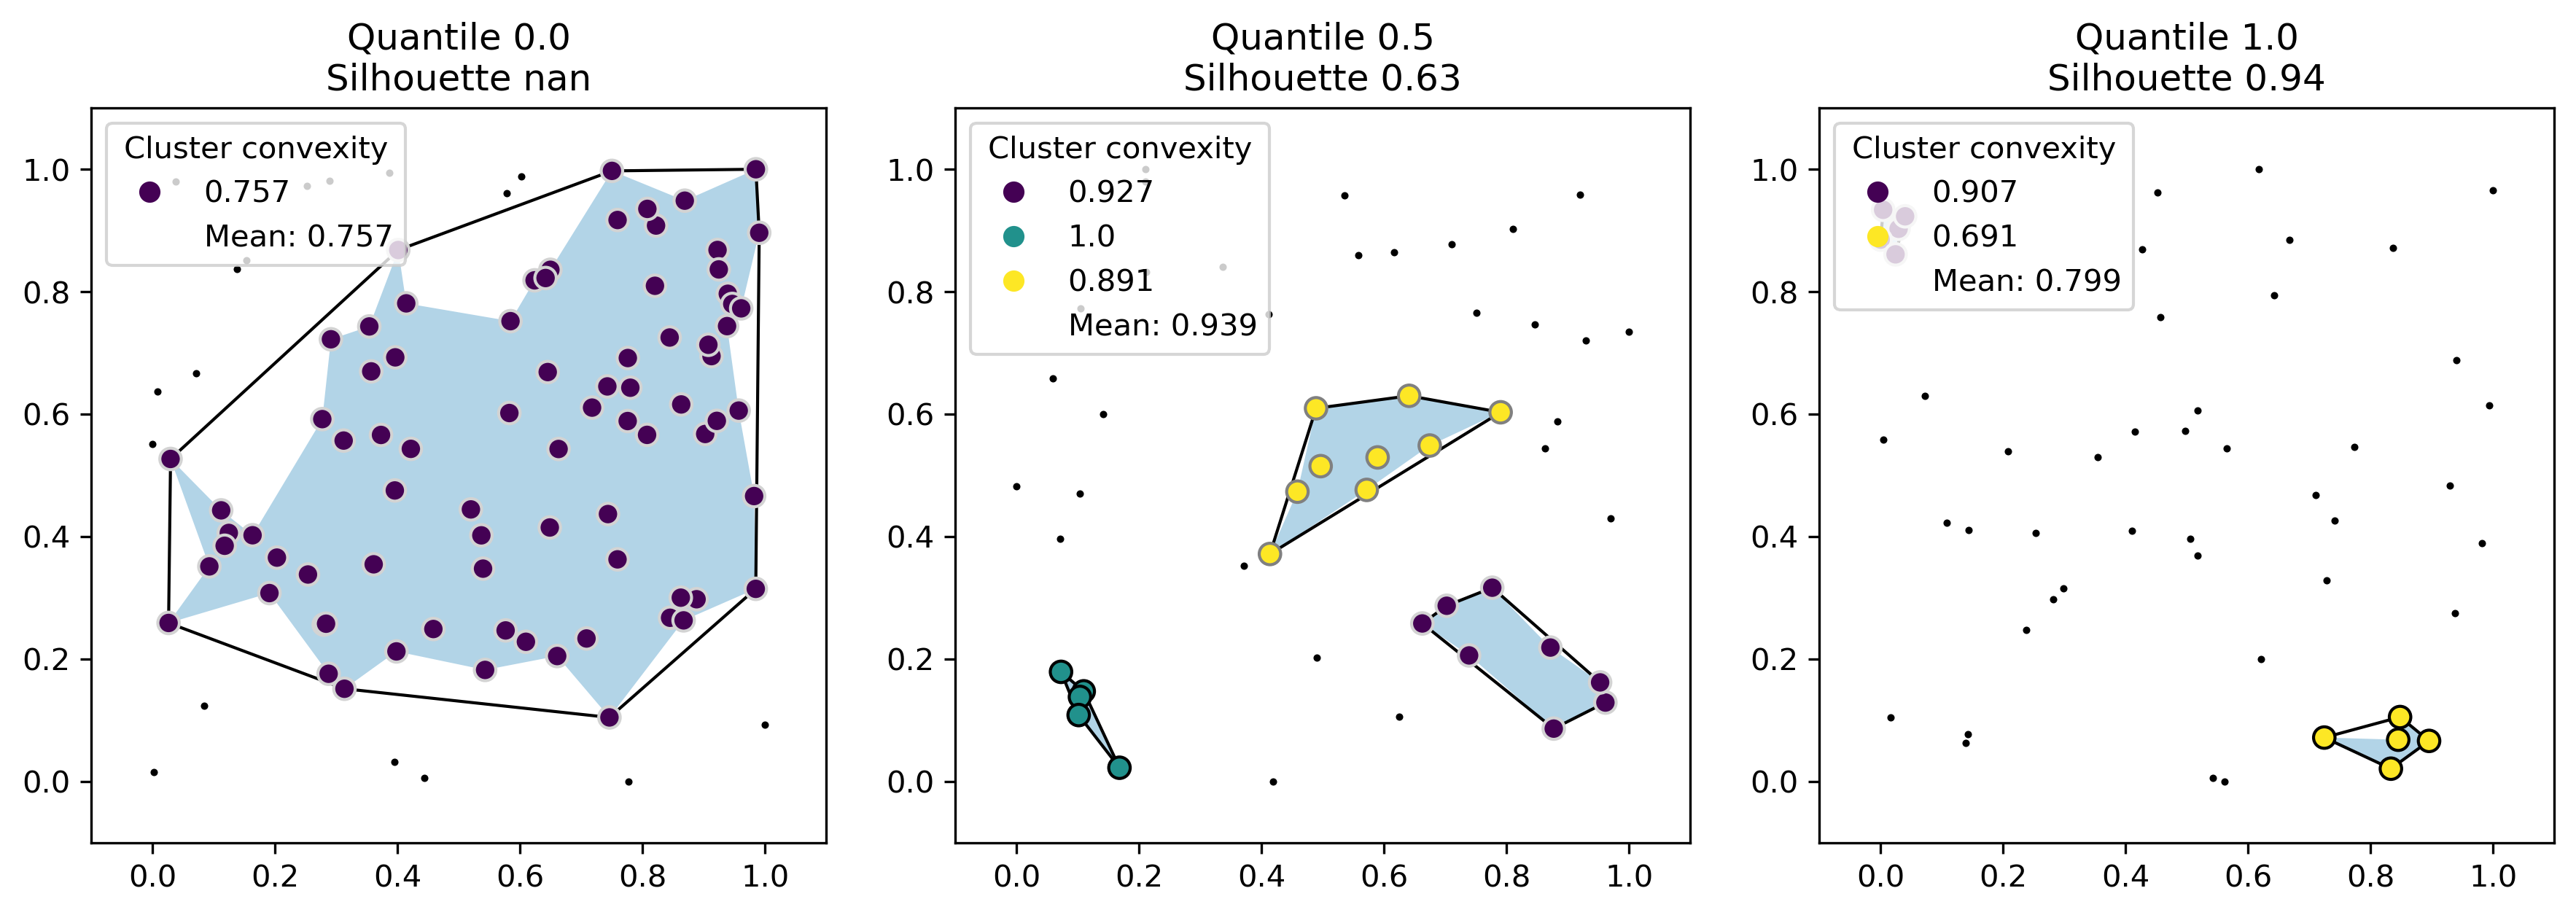

In [26]:
convexity_scatterplot(
    out,
    "dbscan",
#     filename=name + "dbscan_inds.pdf"
)

## Coverage

In [ ]:
_, ax = plt.subplots(dpi=300)

